<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d5t2_fixes/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/W2D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Time series for Language

**Week 2, Day 5: Time Series And Natural Language Processing**

**By Neuromatch Academy**

__Content creators:__ Lyle Ungar, Kelson Shilling-Scrivo, Alish Dipani

__Content reviewers:__ Kelson Shilling-Scrivo 

__Content editors:__ Kelson Shilling-Scrivo

__Production editors:__ Gagana B, Spiros Chavlis

<br>

_Based on Content from: Anushree Hede, Pooja Consul, Ann-Katrin Reuel_

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

----
# Tutorial objectives

Before we begin with exploring how RNNs excel at modelling sequences, we will explore some of the other ways we can model sequences, encode text, and make meaningful measurements using such encodings and embeddings. 

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src="https://mfr.ca-1.osf.io/render?url=https://osf.io/n263c/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/n263c/download).

---
## Setup

In [2]:
# @title Install dependencies

# @markdown There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet
!pip install unidecode --quiet
!pip install nltk --quiet
!pip install d2l==0.16.5 --quiet
!pip install python-Levenshtein --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm
atform = AirtableForm('appn7VdPRseSoMXEG','W2D5_T2','https://portal.neuromatchacademy.org/api/redirect/to/b4d16463-cbc0-4a8c-b0b6-1cbaa428ee7c')

     |█████████████▌                  | 834.1 MB 1.6 MB/s eta 0:11:40tcmalloc: large alloc 1147494400 bytes == 0x396ee000 @  0x7fc81c9f5615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:25tcmalloc: large alloc 1434370048 bytes == 0x7dd44000 @  0x7fc81c9f5615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████▋          | 1336.2 MB 1.2 MB/s eta 0:09:05tcmalloc: large alloc 1792966656 bytes == 0x2b76000 @  0x7fc81c9f5615 0x592b76 0x4df71e 0x59afff 0x515655 0x5

In [3]:
# Imports

import re
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.autograd import Variable

from torchtext.legacy import data, datasets

from d2l import torch as d2l

In [4]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title  Load Dataset from `nltk`
# No critical warnings, so we suppress it
import warnings
warnings.simplefilter("ignore")

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


# Section 1: Recurrent Neural Networks (RNNs)

*Time estimate: ~?mins*

## Section 1.1: Introduction

In [9]:
# @title Video 1: RNNs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="LSMPdQvkXuk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: RNNs')

display(out)

Recurrent neural networks (RNNs), are a family of neural networks for processing sequential data. Just as a convolutional network is specialized for processing a grid of values $X$, such as an image, a recurrent neural network is specialized for processing a sequence of values. RNNs prove useful in many scenarios where other deep learning models are not effective.

* Not all problems can be converted into one with fixed length inputs and outputs.

* The deep learning models we have seen so far pick samples randomly. This might not be the best strategy for a task of understanding meaning from a piece of text. Words in a text occur in a sequence and therefore cannot be permuted randomly to get the meaning.

A related idea is the use of convolution across a 1-D temporal sequence. The convolution operation allows a network to share parameters across time but is shallow. The output of convolution is a sequence where each output is a function of a small number of neighboring inputs. The idea of parameter sharing manifests in applying the same convolution kernel at each time step. Recurrent networks share parameters in a diﬀerent way. Each output is a function of the previous hidden layer, always produced using the same model and weights. This recurrent formulation results in the sharing of parameters through a very deep computational graph.

In [10]:
# @title Video 2: RNN: Basic Architectures
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="T2jzzdSVJI0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: RNNs: Basic Architectures')

display(out)

The following provides more data than the video (but can be skipped for now). For more detail, see the sources, the [deep learning book](https://www.deeplearningbook.org/contents/rnn.html), and [d2l.ai](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)

When the recurrent network is trained to perform a task that requires predicting the future from the past, the network typically learns to use a hidden state at time step $t$, $H_t$ as a kind of lossy summary of the task-relevant aspects of the past sequence of inputs up to $t$. This summary is in general necessarily lossy, since it maps an arbitrary length sequence $(X_t, X_{t-1}, X_{t-2}, \dots , X_{2}, X_{1})$ to a ﬁxed length vector $H_t$.

We can represent the unfolded recurrence after $t$ steps with a function $G_t$:

\begin{equation}
H_t=G_t(X_t, X_{t-1}, X_{t-2}, \dots , X_{2}, X_{1}) = f(H_{t−1}, X_{t}; \theta)
\end{equation}

<br>

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/rnn-2.gif">

<br>

The function $g_t$ takes the whole past sequence $(X_t, X_{t-1}, X_{t-2}, \dots , X_{2}, X_{1})$ as input and produces the current state, but the unfolded recurrent structure allows us to factorize $g_t$ into repeated application of a function $f$. The unfolding process thus introduces two major advantages:

* Regardless of the sequence length, the learned model always has the same input size, because it is speciﬁed in terms of transition from one state to another state, rather than speciﬁed in terms of a variable-length history of states.

* It is possible to use the same transition function $f$ with the same parameters at every time step.


We will now formally write down the equations of a recurrent unit-


Assume that we have a minibatch of inputs $X_t \in R^{n \times d}$ at time step $t$. In other words, for a minibatch of $n$ sequence examples, each row of $X_t$ corresponds to one example at time step $t$ from the sequence. Next, we denote by $H_t \in R^{n \times h}$ the hidden variable of time step $t$. Unlike the MLP, here we save the hidden variable $H_{t-1}$ from the previous time step and introduce a new weight parameter $W_{hh} \in R^{h \times h}$ to describe how to use the hidden variable of the previous time step in the current time step. Specifically, the calculation of the hidden variable of the current time step is determined by the input of the current time step together with the hidden variable of the previous time step:

\begin{equation}
H_t = \phi(X_t W_{xh} + H_{t-1}W_{hh} + b_h)
\end{equation}

For time step $t$, the output of the output layer is similar to the computation in the MLP:

\begin{equation}
O_t = H_t W_{hq} + b_q
\end{equation}
 
Parameters of the RNN include the weights $W_{xh} \in R^{d \times h}, W_{hh} \in R^{h \times h}$ , and the bias $b_h \in R^{1 \times h}$ of the hidden layer, together with the weights $W_{hq} \in R^{h \times q}$ and the bias $b_q \in R^{1 \times q}$ of the output layer. It is worth mentioning that even at different time steps, RNNs always use these model parameters. Therefore, the parameterization cost of an RNN does not grow as the number of time steps increases.

<br>

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/rnn.svg">

### Dataset

We will use the IMDB dataset from <insert link>, which consists of a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. We will use torchtext to download the dataset and prepare it for training, validation and testing. Our goal is to build a model that performs binary classification between positive and negative movie reviews.

We use `fix_length` argument to pad sentences of length less than `sentence_length` or truncate sentences of length greater than `sentence_length`. 

In [11]:
# @title Load dataset function

def download_osf():
  # Download IMDB dataset from OSF
  import tarfile, requests, os
  url = "https://osf.io/dvse9/download"
  fname = "aclImdb_v1.tar.gz"

  print('Downloading Started...')
  # Downloading the file by sending the request to the URL
  r = requests.get(url, stream=True)

  # Writing the file to the local file system
  with open(fname, 'wb') as f:
    f.write(r.content)
  print('Downloading Completed.')

  with tarfile.open(fname) as f:
    # extracting all the files
    print('Extracting all the files now...')
    f.extractall('.data/imdb')  # specify which folder to extract to
    print('Done!')
    os.remove(fname)


def load_dataset(sentence_length=50, batch_size=32, seed=2021):
  """
  Dataset Loader

  Args:
    sentence_length: int
      Length of sentence
    seed: int
      Set seed for reproducibility
    batch_size: int
      Batch size

  Returns:
    TEXT: Field instance
      Text
    vocab_size: int
      Specifies size of TEXT
    train_iter: BucketIterator
      Training iterator
    valid_iter: BucketIterator
      Validation iterator
    test_iter: BucketIterator
      Test iterator
  """
  download_osf()
  TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
  LABEL = data.LabelField(dtype=torch.float)

  train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  # If no specific vector embeddings are specified,
  # Torchtext initializes random vector embeddings
  # which would get updated during training through backpropagation.
  TEXT.build_vocab(train_data)
  LABEL.build_vocab(train_data)

  train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
  train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
  vocab_size = len(TEXT.vocab)

  print(f"Data loading is completed. Sentence length: {sentence_length}, "
        f"Batch size: {batch_size}, and seed: {seed}")

  return TEXT, vocab_size, train_iter, valid_iter, test_iter

The cell below can take 15-30 secs to run.

In [12]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)

Extracting all the files now...
Done!
Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021


Let's see what the data looks like. The words in the reviews are tokenized using the NLTK `word_tokenize` function.  

In [13]:
# @title Explore Dataset

def text_from_dict(arr, dictionary):
  text = []
  for element in arr:
    text.append(dictionary[element])
  return text


for idx, batch in enumerate(train_iter):
  text = batch.text[0]
  target = batch.label

  for itr in range(25,30):
    print('Review: ', ' '.join(text_from_dict(text[itr], TEXT.vocab.itos)))
    print('Label: ', int(target[itr].item()), '\n')

  print('[0: Negative Review, 1: Positive Review]')
  if idx == 0:
    break

Review:  stargate sg-1 is a spin off of sorts from the 1994 movie `` stargate . '' i am so glad that they decided to expand on the subject . the show gets it rolling from the very first episode , a retired jack o'neill has to go through the gate
Label:  1 

Review:  name just says it all . i watched this movie with my dad when it came out and having served in korea he had great admiration for the man . the disappointing thing about this film is that it only concentrate on a short period of the man 's life
Label:  1 

Review:  i saw `` el mar '' yesterday and thought it to be a great movie . it starts with a childhood episode in the life of the 3 main characters : ramallo , manuel tur , and francisca . after that we jump about 10 years to an hospital where
Label:  1 

Review:  what a long , drawn-out , pointless movie . i 'm sure that historically this film is delightful but as entertainment goes it just does n't make the grade . ralph fiennes has been in some fantastic movies , the eng

In [14]:
# @title Helper Functions
# @markdown * `train(model, device, train_iter, valid_iter, epochs, learning_rate)`

# @markdown * `test(model, device, test_iter)`

# @markdown * `plot_train_val(x, train, val, train_label, val_label, title)`


# training
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)

      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}% \n')

  return train_loss, train_acc, validation_loss, validation_acc


# testing
def test(model, device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc


# helpers
def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title(title)
  plt.show()


def count_parameters(model):
  parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameters


def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
      nn.init.xavier_uniform_(m.weight)

## Section 1.2: 1D CNN

In [15]:
# @title Video 3: Time Series
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="JAjuG0o4_Xc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: Time Series')

display(out)

Over the last tutorials, you were introduced to CNNs and used them to work on a range of interesting deep learning applications in vision. You also discussed where else these networks might be useful. Can we apply CNNs to language?

Before we jump into RNNs we will create a CNN model for the text classification task. Let us understand how a one-dimensional convolutional layer works.

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/conv1d.svg">

The above figure shows one-dimensional cross-correlation operation. The shaded parts are the first output element as well as the input and kernel array elements used in its calculation: $0 \cdot 1 + 1 \cdot 2 = 2$.

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/conv1d-channel.svg">

The above figure shows one-dimensional cross-correlation operation with three input channels. The shaded parts are the first output element as well as the input and kernel array elements used in its calculation: $0 \cdot 1 + 1 \cdot 2 \cdot 1 \cdot 3 + 2 \cdot 4 + 2 \cdot (−1) + 3 \cdot (−3) = 2$.

Similarly, we have a one-dimensional pooling layer. The max-over-time pooling layer used in CNN actually corresponds to a one-dimensional global maximum pooling layer. Assuming that the input contains multiple channels, and each channel consists of values on different time steps, the output of each channel will be the largest value of all time steps in the channel. Therefore, the input of the max-over-time pooling layer can have different time steps on each channel.

Fitting all the pieces together a 1D CNN architecture looks like the image below.

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/textcnn.svg">

In this figure, we have an input sequence of 11 words, each with 6 channels. Our model consists of two Conv1D layers applied to this input: one of kernel size 2 having 4 output channels and one of kernel size 4 having 5 output channels.  The max-over-time pooling is applied to each of the output channels. The max-pooled outputs for each output channel of the Conv1D layers are concatenated to form 1x4 and 1x5 vectors respectively. Finally these outputs are further concatenated to form a vector of 1x9 and this is passed to a fully connected layer of size 2 for binary classification. 

The intuition of using a max-pooling over different channels here is to capture the most important features over time in an input sequence.

### Coding Exercise 1: Implement a 1D CNN

Now it's your turn to implement a 1D CNN. 

* Here we will use [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)  layer instead of pretrained word embeddings. This is a design choice. Using `nn.Embedding` layer in the network allows us to train word embeddings specific to the problem at hand. You are given the `vocab_size` which is the size of the dictionary of embeddings, and the `embed_size` which is the size of each embedding vector. 

* The 1D CNN should work for any number kernel size and corresponsing number of channels. Both `kernel_sizes` and `num_channels` are lists. Each element of these lists corresponds to the kernel size and output channels of a Conv1D layer.

* Use [adaptive max pooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html) 

* Determine the size of inputs and outputs to the fully-connected layer using the reference example given above.  

In [16]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                **kwargs):
    super(TextCNN, self).__init__(**kwargs)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("TextCNN")
    ####################################################################
    self.embedding = ...
    self.fc = ...
    self.pool = ...
    self.relu = ...
    self.convs = nn.ModuleList()
    # This for loop adds the Conv1D layers to your network
    for c, k in zip(num_channels, kernel_sizes):
      # Conv1d(in_channels, out_channels, kernel_size)
      self.convs.append(nn.Conv1d(embed_size, c, k))

  def forward(self, inputs):
    embeddings = self.embedding(inputs)
    embeddings = embeddings.permute(0, 2, 1)
    # Concatenating the average-pooled outputs
    encoding = torch.cat([
        torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
        for conv in self.convs], dim=1)
    outputs = self.fc(encoding)
    return outputs


## Uncomment to test
# sampleCNN = TextCNN(1000, 300, [1, 2, 3], [10, 20, 30])
# print(sampleCNN)

# add event to airtable
atform.add_event('Coding Exercise 1: Implement a 1D CNN')

Sample output

```python
TextCNN(
  (embedding): Embedding(1000, 300)
  (fc): Linear(in_features=60, out_features=2, bias=True)
  (pool): AdaptiveMaxPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(300, 10, kernel_size=(1,), stride=(1,))
    (1): Conv1d(300, 20, kernel_size=(2,), stride=(1,))
    (2): Conv1d(300, 30, kernel_size=(3,), stride=(1,))
  )
)
```

In [17]:
# to_remove solution
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                **kwargs):
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.fc = nn.Linear(sum(num_channels), 2)
    self.pool = nn.AdaptiveMaxPool1d(1)
    self.relu = nn.ReLU()
    self.convs = nn.ModuleList()
    # This for loop adds the Conv1D layers to your network
    for c, k in zip(num_channels, kernel_sizes):
      # Conv1d(in_channels, out_channels, kernel_size)
      self.convs.append(nn.Conv1d(embed_size, c, k))

  def forward(self, inputs):
    embeddings = self.embedding(inputs)
    embeddings = embeddings.permute(0, 2, 1)
    # Concatenating the average-pooled outputs
    encoding = torch.cat([
        torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
        for conv in self.convs], dim=1)

    outputs = self.fc(encoding)
    return outputs


## Uncomment to test
sampleCNN = TextCNN(1000, 300, [1, 2, 3], [10, 20, 30])
print(sampleCNN)

# add event to airtable
atform.add_event('Coding Exercise 1: Implement a 1D CNN')

TextCNN(
  (embedding): Embedding(1000, 300)
  (fc): Linear(in_features=60, out_features=2, bias=True)
  (pool): AdaptiveMaxPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(300, 10, kernel_size=(1,), stride=(1,))
    (1): Conv1d(300, 20, kernel_size=(2,), stride=(1,))
    (2): Conv1d(300, 30, kernel_size=(3,), stride=(1,))
  )
)


Epoch: 1,  Training Loss: 0.8995, Training Accuracy:  51.47%
Validation Loss: 0.7561, Validation Accuracy:  52.31% 

Epoch: 2,  Training Loss: 0.7404, Training Accuracy:  53.61%
Validation Loss: 0.7435, Validation Accuracy:  53.33% 

Epoch: 3,  Training Loss: 0.7201, Training Accuracy:  55.48%
Validation Loss: 0.7336, Validation Accuracy:  54.45% 

Epoch: 4,  Training Loss: 0.7016, Training Accuracy:  57.14%
Validation Loss: 0.7252, Validation Accuracy:  55.37% 

Epoch: 5,  Training Loss: 0.6851, Training Accuracy:  58.90%
Validation Loss: 0.7166, Validation Accuracy:  56.28% 

Epoch: 6,  Training Loss: 0.6697, Training Accuracy:  60.25%
Validation Loss: 0.7112, Validation Accuracy:  56.65% 

Epoch: 7,  Training Loss: 0.6556, Training Accuracy:  61.65%
Validation Loss: 0.7036, Validation Accuracy:  57.68% 

Epoch: 8,  Training Loss: 0.6419, Training Accuracy:  62.98%
Validation Loss: 0.6988, Validation Accuracy:  58.00% 

Epoch: 9,  Training Loss: 0.6291, Training Accuracy:  64.33%
Val

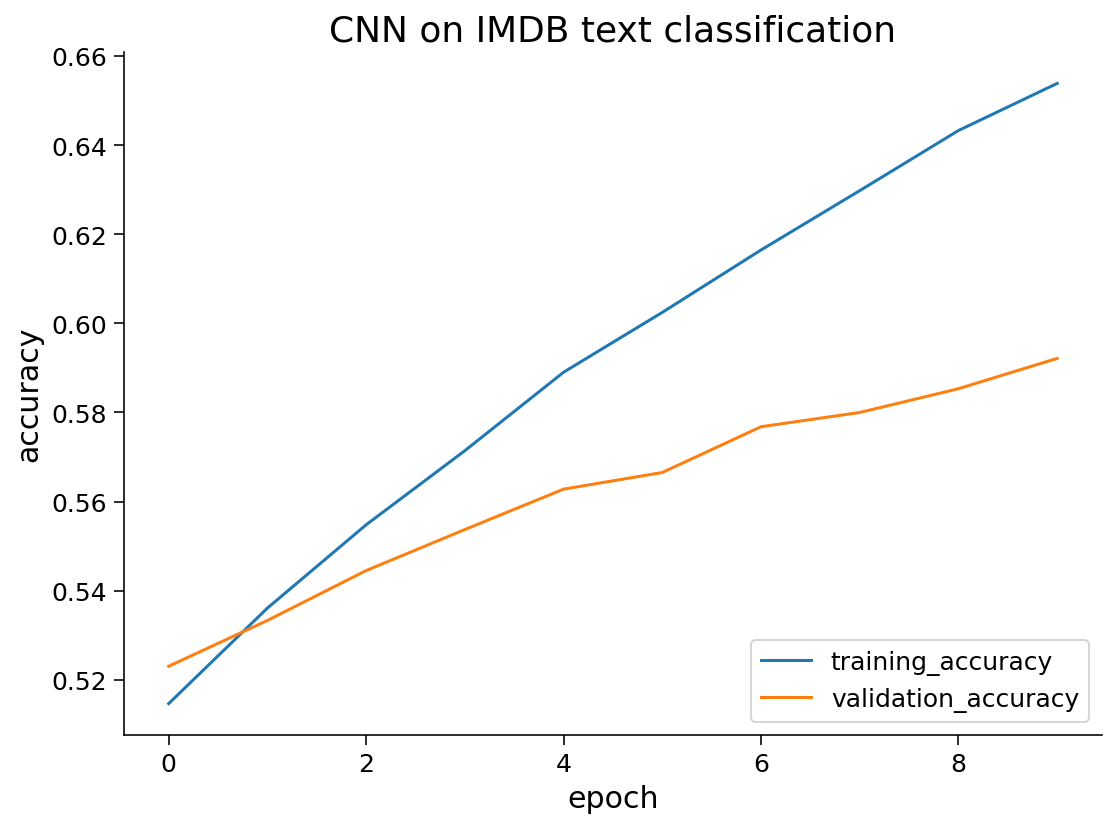



Number of parameters = 11294002


In [18]:
# Model hyperparameters
learning_rate = 0.00001
embedding_length = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 100, 100]
epochs = 10

# Initialize model, training and testing
cnn_model = TextCNN(vocab_size, embedding_length, kernel_sizes, nums_channels)
cnn_model.to(DEVICE)
cnn_model.apply(init_weights)
cnn_start_time = time.time()
cnn_train_loss, cnn_train_acc, cnn_validation_loss, cnn_validation_acc = train(cnn_model, DEVICE, train_iter, valid_iter, epochs, learning_rate)
print(f"--- Time taken to train = {time.time() - cnn_start_time} seconds ---")
test_accuracy = test(cnn_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy}%')

# Plot accuracies
plot_train_val(np.arange(0, epochs),
               cnn_train_acc,
               cnn_validation_acc,
               'training_accuracy',
               'validation_accuracy',
               'CNN on IMDB text classification')

# Number of parameters in model
paramters = count_parameters(cnn_model)
print(f'\n\nNumber of parameters = {paramters}')

## Section 1.3: Vanilla RNN

### Coding Exercise 2: Implement a Vanilla RNN

Now it's your turn to write a Vanilla RNN using PyTorch.

* Once again we will use `nn.Embedding`. You are given the `vocab_size` which is the size of the dictionary of embeddings, and the `embed_size` which is the size of each embedding vector.  

* Add 2 [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) layers. This would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results.

* Determine the size of inputs and outputs to the fully-connected layer.


In [19]:
class VanillaRNN(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(VanillaRNN, self).__init__()
      ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Vanilla RNN")
    ####################################################################
    self.hidden_size = ...
    self.word_embeddings = ...
    self.rnn = ...
    self.fc = ...

  def forward(self, inputs):
    input = self.word_embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size).to(DEVICE))
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)

    return logits


## Uncomment to test
# sampleRNN = VanillaRNN(10, 50, 1000, 300)
# print(sampleRNN)

# add event to airtable
atform.add_event('Coding Exercise 2: Implement a Vanilla RNN')

Sample output

```python
VanillaRNN(
  (word_embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
```

In [20]:
# to_remove solution
class VanillaRNN(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(VanillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2)
    self.fc = nn.Linear(2*hidden_size, output_size)

  def forward(self, inputs):
    input = self.word_embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size).to(DEVICE))
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)

    return logits


## Uncomment to test
sampleRNN = VanillaRNN(10, 50, 1000, 300)
print(sampleRNN)

# add event to airtable
atform.add_event('Coding Exercise 2: Implement a Vanilla RNN')

VanillaRNN(
  (word_embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


Epoch: 1,  Training Loss: 0.6970, Training Accuracy:  51.30%
Validation Loss: 0.6965, Validation Accuracy:  50.57% 

Epoch: 2,  Training Loss: 0.6821, Training Accuracy:  56.31%
Validation Loss: 0.6829, Validation Accuracy:  56.67% 

Epoch: 3,  Training Loss: 0.6671, Training Accuracy:  58.89%
Validation Loss: 0.6955, Validation Accuracy:  54.29% 

Epoch: 4,  Training Loss: 0.6528, Training Accuracy:  61.84%
Validation Loss: 0.6730, Validation Accuracy:  60.03% 

Epoch: 5,  Training Loss: 0.6230, Training Accuracy:  65.73%
Validation Loss: 0.6593, Validation Accuracy:  61.73% 

Epoch: 6,  Training Loss: 0.5996, Training Accuracy:  68.34%
Validation Loss: 0.6546, Validation Accuracy:  63.04% 

Epoch: 7,  Training Loss: 0.5738, Training Accuracy:  70.91%
Validation Loss: 0.6520, Validation Accuracy:  64.71% 

Epoch: 8,  Training Loss: 0.5572, Training Accuracy:  72.02%
Validation Loss: 0.6809, Validation Accuracy:  58.47% 

Epoch: 9,  Training Loss: 0.5490, Training Accuracy:  72.45%
Val

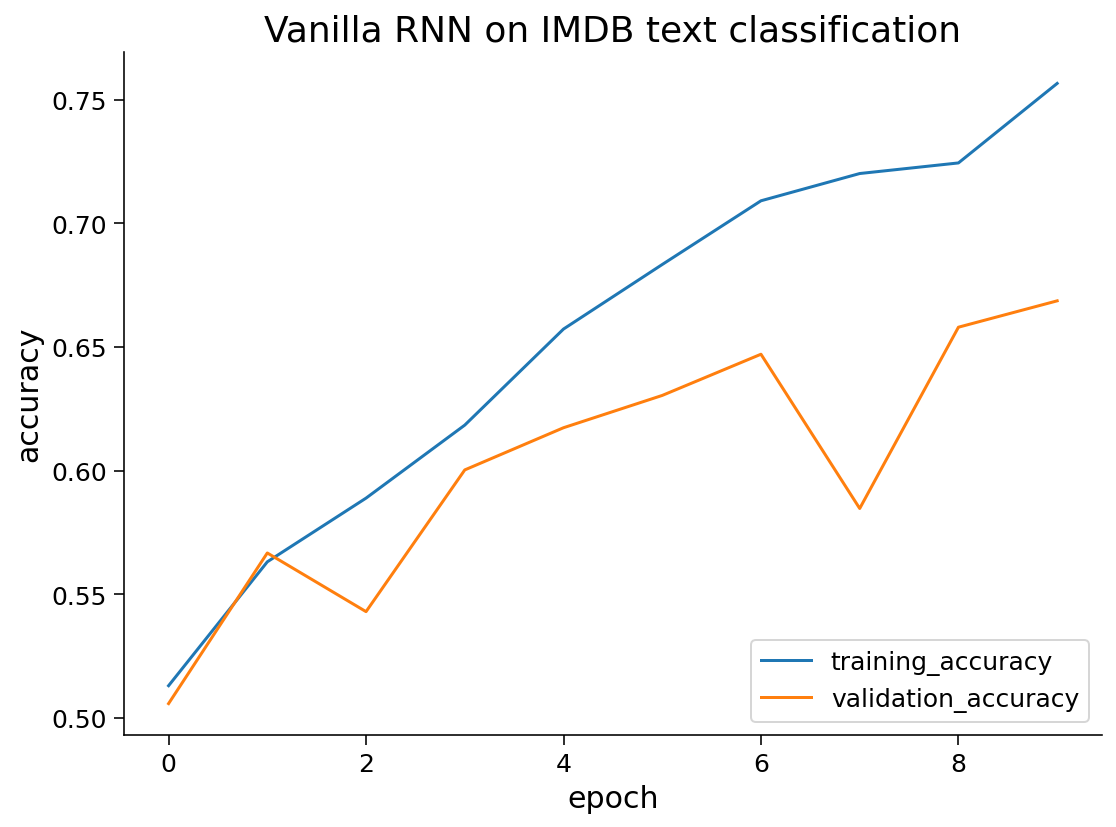



Number of parameters = 11213902


In [21]:
# Model hyperparamters
learning_rate = 0.0002
output_size = 2
hidden_size = 100
embedding_length = 100
epochs = 10

# Initialize model, training and testing
vanilla_rnn_model = VanillaRNN(output_size, hidden_size, vocab_size, embedding_length)
vanilla_rnn_model.to(DEVICE)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model, DEVICE, train_iter, valid_iter, epochs, learning_rate)
print(f"--- Time taken to train = {time.time() - vanilla_rnn_start_time} seconds ---")
test_accuracy = test(vanilla_rnn_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy}%')

# Plot accuracy curves
plot_train_val(np.arange(0, epochs), vanilla_train_acc, vanilla_validation_acc,
               'training_accuracy', 'validation_accuracy',
               'Vanilla RNN on IMDB text classification')

# Number of model parameters
paramters = count_parameters(vanilla_rnn_model)
print(f'\n\nNumber of parameters = {paramters}')

# Section 2: RNN applications and Language Models

*Time estimate: ~?mins*

### **Important!** 

In this section, you will use your knowledge of recurrent neural networks and build some interesting NLP applications! For the remainder of the tutorial we will be switching from word-level models to character-level models; which means the text will be tokenized at the character level. We do this in the interest of simplifying our task by limiting our vocabulary (which is now a set of characters instead of words).   

In [22]:
# @title Video 4: RNN Architectures for NLP
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="R3Dg7wBQQoU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 4: RNN Architectures for NLP')

display(out)

## Section 2.1: Text Generation and Language Modelling


In [23]:
# @title Video 5: Sequence Modeling
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="wYuvMGQdpI4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 5: Sequence Modeling')

display(out)

The first application we will discuss in this section is that of text generation using neural language models. In linguistic theory, a language model is a probability distribution over sequences of words. The task for the model is posed as follows: given a history or context of words, can you predict the next word in the sequence? 

Recurrent neural networks are a natural choice for this task, since they have the ability to capture information from past observations through the hidden state. Andrej Karpathy's [blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is an excellent read for developing intuition for this task. For this exercise, you will train a character-level text generation model, give it an initial "start" string, and watch how it generates characters! 

At any given time step, the model takes one character and a hidden state as input. We convert the output of the model to a probability distribution over the possible characters, and pick a character from this distribution as the next prediction. This "generated" character is then passed to the model as the input in the next time step. This process is repeated for a fixed number of time steps.  (In real generation, these is often a special "stop character" that determines when to stop generation.   

<br>

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/rnnW2D5T2.png"> 


**Note:** Language models are generally evaluated using a metric known as [perplexity](https://towardsdatascience.com/perplexity-intuition-and-derivation-105dd481c8f3), which is 2 to the entropy of the probability distribution of the language model, measured in bits.

References:
- [RNN PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
- [RNN d2l.ai tutorial](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html#rnn-based-character-level-language-models)

In [24]:
# @markdown Preparing the input (run me)

import requests

url = "https://osf.io/f6z3p/download"
fname = "1522-0.txt"
r = requests.get(url, stream=True)
with open(fname, "wb") as f:
  f.write(r.content)
print(f"The file '{fname}' has been downloaded.")


# Print a random chunk from the training data
def random_chunk(chunk_len):
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    tensor[c] = all_characters.index(string[c])
  return tensor


# Get a random chunk from the traning data,
# Convert its first n-1 chars into input char tensor
# Convert its last n-1 chars into target char tensor
def random_training_set(chunk_len):
  chunk = random_chunk(chunk_len)
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target


# Read the input training file - Julius Caesar
file = unidecode.unidecode(open('1522-0.txt').read()).lower()
file = re.sub(r'[^a-z]+', ' ', file)
file_len = len(file)
print(f'\nLength of {fname} file is {file_len}')

chunk_len = 100
print(f"\nRandom chunk: {random_chunk(chunk_len)}")

# Get all printable characters for generation
# all_characters = string.printable
all_characters = string.ascii_lowercase
all_characters += ' '
n_characters = len(all_characters)

The file '1522-0.txt' has been downloaded.

Length of 1522-0.txt file is 127899

Random chunk:  was the noblest roman of them all all the conspirators save only he did that they did in envy of gre


**Network**

In [25]:
class GenerationRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(GenerationRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers

    self.encoder = nn.Embedding(input_size, hidden_size)
    self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
    self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    input = self.encoder(input.view(1, -1))
    output, hidden = self.rnn(input, hidden)
    output = self.decoder(hidden.view(1, -1))
    return output, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

### Coding Exercise 3: Implement Text generation

Examine the network example above and write the function below that:
* Takes in a `prime_str` and builds up a hidden state 
* Uses the built up hidden state to iteratively generate `predict_len` number of characters from the model
* To predict the next state, softmax the output from the model and pick the character with the maximum probability 

In [26]:
def evaluate(net, all_characters, prime_str, predict_len):
  hidden = net.init_hidden()
  predicted = prime_str

  # "Building up" the hidden state
  for p in range(len(prime_str) - 1):
    inp = char_tensor(prime_str[p])
    _, hidden = net(inp, hidden)

  # Tensorize of the last character
  inp = char_tensor(prime_str[-1])

  # For every index to predict
  for p in range(predict_len):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Generation")
    ####################################################################
    # Pass the inputs to the model
    output, hidden = ...

    # Pick the character with the highest probability
    top_i = ...

    # Add predicted character to string and use as next input
    predicted_char = all_characters[top_i]
    predicted += predicted_char
    inp = char_tensor(predicted_char)

  return predicted


## Uncomment to run
# sampleDecoder = GenerationRNN(27, 100, 27, 1)
# text = evaluate(sampleDecoder, all_characters, 'hi', 10)
# if text.startswith('hi') and len(text) == 12:
#   print('Success!')
# else:
#   print('Need to change.')

# add event to airtable
atform.add_event('Coding Exercise 3: Implement Text generation')

In [27]:
# to_remove solution
def evaluate(net, all_characters, prime_str, predict_len):
  hidden = net.init_hidden()
  predicted = prime_str

  # "Building up" the hidden state
  for p in range(len(prime_str) - 1):
    inp = char_tensor(prime_str[p])
    _, hidden = net(inp, hidden)

  # Tensorize of the last character
  inp = char_tensor(prime_str[-1])

  # For every index to predict
  for p in range(predict_len):
    # Pass the inputs to the model
    output, hidden = net(inp, hidden)

    # Pick the character with the highest probability
    top_i = torch.argmax(torch.softmax(output, dim=1))

    # Add predicted character to string and use as next input
    predicted_char = all_characters[top_i]
    predicted += predicted_char
    inp = char_tensor(predicted_char)

  return predicted


## Uncomment to run
sampleDecoder = GenerationRNN(27, 100, 27, 1)
text = evaluate(sampleDecoder, all_characters, 'hi', 10)
if text.startswith('hi') and len(text) == 12:
  print('Success!')
else:
  print('Need to change.')

# add event to airtable
atform.add_event('Coding Exercise 3: Implement Text generation')

Success!


Epoch 500 --------------------
	 the the the the the the the the the the the the the 
Epoch 1000 --------------------
	 the the the the the the the the the the the the the 
Epoch 1500 --------------------
	 the the the the the the the the the the the the the 
Epoch 2000 --------------------
	 the the the the the the the the the the the the the 
Epoch 2500 --------------------
	 ther the the the the the the the the the the the the
Epoch 3000 --------------------
	 the the the the the the the the the the the the the 




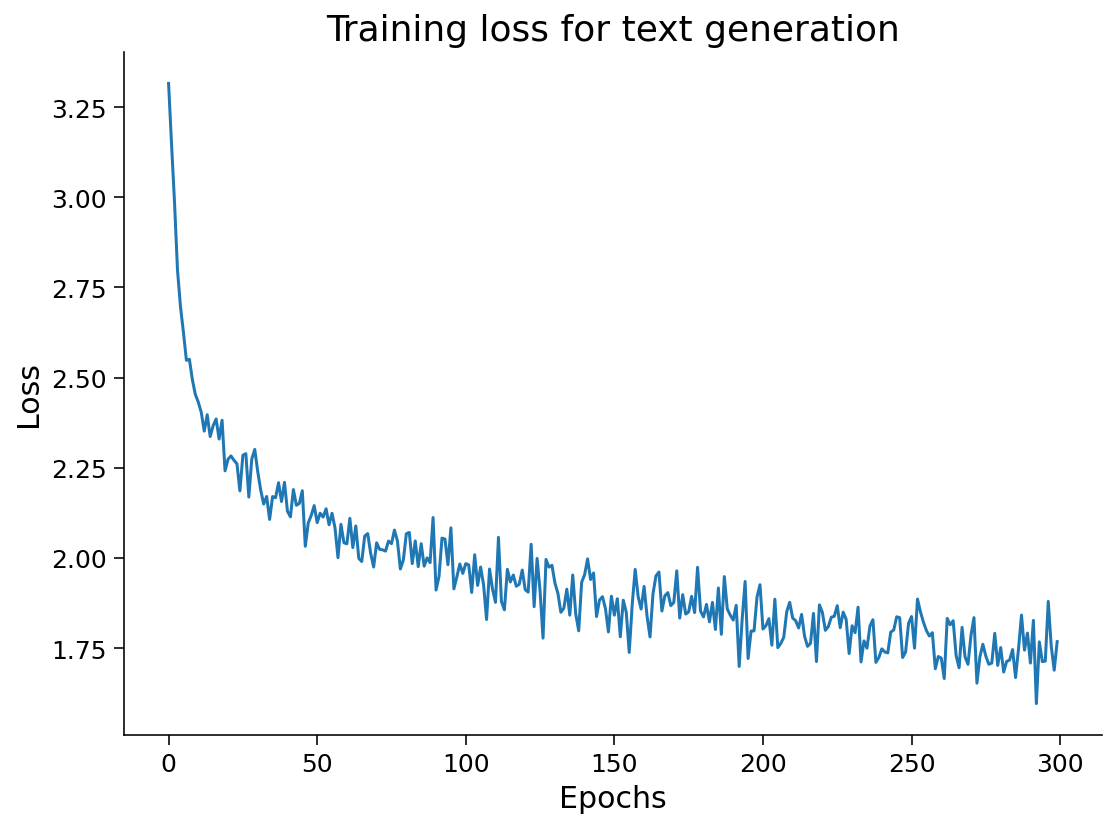

In [28]:
# @markdown Run this cell to train the model

def grad_clipping(net, theta):
  """Clip the gradient."""
  params = [p for p in net.parameters() if p.requires_grad]

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))

  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm


# Single training step
def train_gen(inp, target, chunk_len):
  # Initialize hidden state, zero the gradients of decoder
  hidden = decoder.init_hidden()
  decoder.zero_grad()
  loss = 0
  # For each character in our chunk (except last), compute the hidden and ouput
  # Using each output, compute the loss with the corresponding target
  for c in range(chunk_len):
    output, hidden = decoder(inp[c], hidden)
    loss += criterion(output, target[c].unsqueeze(0))

  # Backpropagate, clip gradient and optimize
  loss.backward()
  grad_clipping(decoder, 1)
  decoder_optimizer.step()

  # Return average loss
  return loss.data.item() / chunk_len


n_epochs = 3000
hidden_size = 100
n_layers = 1
lr = 0.0005
print_every, plot_every = 500, 10

# Create model, optimizer and loss function
decoder = GenerationRNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

# For every epoch
for epoch in range(1, n_epochs + 1):
  # Get a random (input, target) pair from training set and perform one training iteration
  loss = train_gen(*random_training_set(chunk_len), chunk_len)
  loss_avg += loss

  if epoch % print_every == 0:
    text = evaluate(decoder, all_characters, 'th', 50)
    print(f'Epoch {epoch} --------------------\n\t {text}')

  if epoch % plot_every == 0:
    all_losses.append(loss_avg / plot_every)
    loss_avg = 0

print('\n')
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss for text generation')
plt.show()

## Section 2.2: Sequence Tagging



In [29]:
# @title Video 6: Tagging
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="Wnj9XZdtV7I", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 6: Tagging')

display(out)

Sequence tagging is a task in machine learning whose goal is to assign a label (or category) to each unit of a sequence processed in a model. In natural language processing, some popular tagging tasks include parts-of-speech tagging and named entity recognition. 

Formally, we study tagging as a different task from language modeling or text generation, but there are similarities between them. Instead of choosing the next best character from the output model, we pass the hidden state of each recurrent unit from the model to a fully connected layer and assign it a label.   

In [30]:
# @markdown Build the dataloader (run me!)
class TaggingDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'

  def __init__(self, raw_data):
    'Initialization'
    self.data = raw_data
    self.vowels = ['a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U']

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.data)

  def __getitem__(self, index):
    'Generates one sample of data'
    # Select sample
    inp = char_tensor(self.data[index][:-1])
    target = []
    for c in self.data[index][1:]:
      if c in self.vowels:
        target.append(0)
      elif c == ' ':
        target.append(1)
      else:
        target.append(2)
    target = torch.tensor(target)
    # print(self.data[index][:-1], target)
    return inp, target


# Data loaders
raw_data = []
for i in range(100):
  raw_data.append(random_chunk(chunk_len))
dataset = TaggingDataset(raw_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

### Coding Exercise 4: Implement Sequence Labelling

For this exercise, you will train a character-level sequence labeling model on the same dataset as the previous exercise.

The model takes in a character and a hidden state vector as input and predicts whether the **next** character in the sequence will be a vowel (V), space (S), or other (O). Much of the code for this task is identical to the code for text generation, so you will be making the most critical tweaks in the text generation pipeline that will give you a tagging pipeline. Note that the task becomes simpler since we are reducing the prediction space to just three classes.

Structurally, the tagging model looks similar to the text generation one, except the Linear layer must map to the number of tags or labels defined for your task. Functionally, the hidden state (instead of the output) must be mapped to the Linear layer to perform the classification of the required unit.

In [31]:
class TaggingRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(TaggingRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Tagging Init")
    ####################################################################
    self.embedding = ...
    # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    self.rnn = ...
    self.linear = ...

  def forward(self, input, hidden):
    input = self.embedding(input.view(1, -1))
    output, hidden = self.rnn(input.view(1, 1, -1), hidden)
    out = self.linear(hidden)
    return out, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)
## Uncomment to run
# sampleTagger = TaggingRNN(20, 100, 10, 2)
# print(sampleTagger)

# add event to airtable
atform.add_event('Coding Exercise 4: Implement Sequence Labelling')

Sample output

```python
TaggingRNN(
  (embedding): Embedding(20, 100)
  (rnn): RNN(100, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)
```

In [32]:
# to_remove solution
class TaggingRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(TaggingRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size, hidden_size)
    # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
    self.linear = nn.Linear(hidden_size, 3)

  def forward(self, input, hidden):
    input = self.embedding(input.view(1, -1))
    output, hidden = self.rnn(input.view(1, 1, -1), hidden)
    out = self.linear(hidden)
    return out, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)


## Uncomment to run
sampleTagger = TaggingRNN(20, 100, 10, 2)
print(sampleTagger)

# add event to airtable
atform.add_event('Coding Exercise 4: Implement Sequence Labelling')

TaggingRNN(
  (embedding): Embedding(20, 100)
  (rnn): RNN(100, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)


### Evaluation

Here is a function that performs the "Vowel/Space/Other" tagging task for each character of the given string. You don't need to code anything.  

**Bonus task:** notice the similarities between it and the evaluation code for the text generation task.

In [33]:
# @markdown Evaluation function

def evaluate(model, prime_str, predict_len):
  labels = ['Vowel', 'Space', 'Other']

  hidden = model.init_hidden()
  prime_input = char_tensor(prime_str)
  build_up = len(prime_str) - predict_len
  predicted = prime_str[:build_up]

  # Use priming string to "build up" hidden state
  for p in range(build_up):
    _, hidden = model(prime_input[p], hidden)

  column_width = len('milan_is_a_nice_place')+2

  print('Text {}'.ljust(column_width) + 'Next Character is ...\n-------------------------')

  # For each character remaining to be tagged
  for p in range(0, predict_len):
    # Get it's input tensor
    inp = prime_input[build_up + p]
    next_char = prime_str[build_up + p]
    predicted += next_char

    # Pass the input and the previous hidden state to the model
    out, hidden = model(inp, hidden)

    # Softmax the output and find the best tag
    softmax = torch.softmax(out[0], dim=1, dtype=torch.float)
    i = torch.argmax(softmax)
    label = labels[i]

    text = predicted.replace(' ', '_')
    print(text.ljust(column_width) + label)

### Training


------ Epoch 5
Text {}                Next Character is ...
-------------------------
milan_i                Other
milan_is               Space
milan_is_              Other
milan_is_a             Other
milan_is_a_            Other
milan_is_a_n           Vowel
milan_is_a_ni          Other
milan_is_a_nic         Other
milan_is_a_nice        Other
milan_is_a_nice_       Other
milan_is_a_nice_p      Vowel
milan_is_a_nice_pl     Vowel
milan_is_a_nice_pla    Other
milan_is_a_nice_plac   Vowel
milan_is_a_nice_place  Other

------ Epoch 10
Text {}                Next Character is ...
-------------------------
milan_i                Space
milan_is               Space
milan_is_              Other
milan_is_a             Other
milan_is_a_            Other
milan_is_a_n           Vowel
milan_is_a_ni          Other
milan_is_a_nic         Other
milan_is_a_nice        Other
milan_is_a_nice_       Other
milan_is_a_nice_p      Vowel
milan_is_a_nice_pl     Vowel
milan_is_a_nice_pla    Other
milan_is_a_ni

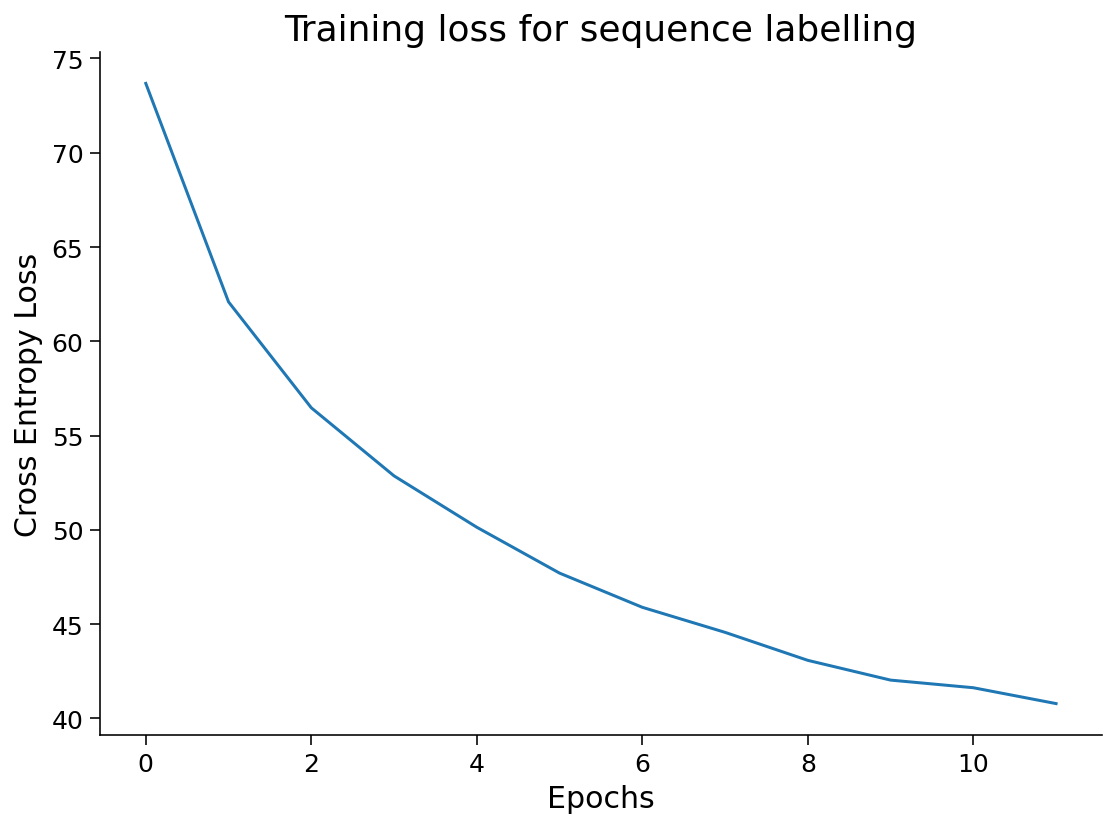

In [34]:
# @markdown Run this cell to train the model!

# Single training step
def train_simple(inp, target, chunk_len):
  # Initialize hidden state, zero the gradients of decoder
  hidden = tagger.init_hidden()
  tagger.zero_grad()
  loss = 0

  # For each character in our chunk (except last), compute the hidden and ouput
  # Using each output, compute the loss with the corresponding target
  for c in range(chunk_len):
    out, hidden = tagger(inp[c], hidden)
    loss += criterion(out[0], target[c].unsqueeze(0))

  # Backpropagate and optimize
  loss.backward()
  optimizer.step()

  # Return average loss
  return loss.data.item() / chunk_len


# Define the parameters
n_epochs = 12
hidden_size = 100
n_layers = 1
lr = 0.005

print_every, plot_every = 5, 1

# Create model, optimizer and loss function
tagger = TaggingRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(tagger.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

# For every epoch
for epoch in range(1, n_epochs + 1):

  for i, (input, target) in enumerate(dataloader):
    loss = train_simple(input[0], target[0], chunk_len)
    loss_avg += loss

  if epoch % print_every == 0:
    print(f'\n------ Epoch {epoch}')
    evaluate(tagger, 'milan is a nice place', 15)

  if epoch % plot_every == 0:
    all_losses.append(loss_avg / plot_every)
    loss_avg = 0

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training loss for sequence labelling')
plt.show()

## Section 2.3: Sequence to Sequence 



In [35]:
# @title Video 7: Seq2Seq
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="6uJHra_esJU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 7: seq2seq')

display(out)

Sequence-to-sequence models take in a sequence of items (words, characters, etc) as input and produces another sequence of items as output. The most 
simple seq2seq models are composed of two parts: the encoder, the context ("state" in the figure) and the decoder. The encoder and decoder usually consist of recurrent units that we've seen before (RNNs, GRUs or LSTMs). A high-level schematic of the architecture is as follows:

<br>

<img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl//main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/static/encdecW2D5T2.png"> 

The encoder's recurrent unit processes the input one item at a time. Once the entire sequence is processed, the final hidden state vector produced is known as a context vector. The size of the context vector is defined while setting up the model, and is equal to the number of hidden states used in the encoder RNN. The encoder then passes the context to the decoder. The decoder's recurrent unit uses the context to produce the items for the output sequence one by one.

Sources:
- [d2l.ai on encoders](https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html)
- [d2l.ai on seq2seq](https://d2l.ai/chapter_recurrent-modern/seq2seq.html)
- [Jalammar's blog](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)

One of the most popular applications of seq2seq models is "machine translation": the task of taking in a sentence in one language (the source) and producing its translation in another language (the target), with words in both languages being the sequence units. This is a supervised learning task and requires the dataset to have "parallel sentences", i.e., each sentence in the source language must be labelled with its translation in the target language. 

[Here](https://i.imgur.com/HJ6t8up.mp4) is an intuitive visualization for understanding **seq2seq** models for machine translation from English to French.

Since the vocabulary of an entire language is huge, training such models to give meaningful performance requires significant time and resources. In this section, you will train a seq2seq model to perform machine translation from English to [Pig-Latin](https://en.wikipedia.org/wiki/Pig_Latin). We will modify the task to perform character-level machine translation so that vocabulary size does not grow exponentially.

In [36]:
# @title Data download and Preprocessing

import os, zipfile, requests, io

url = "https://osf.io/fkg3y/download"
fname = "wordlist-en_US-large-2020.12.07.zip"

print('Downloading Started...')
# Downloading the file by sending the request to the URL
r = requests.get(url, stream=True)

# Writing the file to the local file system
with open(fname, 'wb') as f:
  f.write(r.content)
print('Downloading Completed.')

# opening the zip file in READ mode
with zipfile.ZipFile(fname, 'r') as zipObj:
  # extracting all the files
  print('Extracting all the files now...')
  zipObj.extractall()
  print('Done!')
  os.remove(fname)


def t(str):
  return str[0] + str[1]


def pig_latinize(word):
  lst = ['sh', 'gl', 'ch', 'ph', 'tr', 'br', 'fr', 'bl', 'gr', 'st', 'sl', 'cl', 'pl', 'fl']

  i = word
  if i[0] in ['a', 'e', 'i', 'o', 'u']:
    word = i+'ay'
  elif t(i) in lst:
    word = i[2:] + i[:2] + 'ay'
  elif i.isalpha() == False:
    word = i
  else:
    word = i[1:] + i[0] + 'ay'
  return word

def read_data(fname='en_US-large.txt'):
  word_list = []
  with open(fname) as f:
    word_list.extend(f.readlines())
  clean_wordlist = [unidecode.unidecode(w.strip().lower()) for w in word_list if w.strip().isalpha() and len(w.strip()) > 2 and len(w.strip()) < 6]
  clean_data = []
  for word in clean_wordlist:
    clean_data.append(word + ' ' + pig_latinize(word))
  return clean_data


def tokenize_nmt(text, num_examples=None):
  """Tokenize the English-French dataset."""
  source, target = [], []
  source_char_set = set()
  target_char_set = set()
  for i, line in enumerate(text):
    if num_examples and i > num_examples:
      break
    parts = line.split(' ')
    # parts = line.split('\t')
    if len(parts) == 2:
      src_txt, tgt_txt = parts
      cur_src, cur_tgt = [], []
      for c in src_txt:
        cur_src.append(c)
        source_char_set.add(c)
      for c in tgt_txt:
        cur_tgt.append(c)
        target_char_set.add(c)
      source.append(cur_src)
      target.append(cur_tgt)

  special_tokens = ['<eos>', '<bos>', '<pad>']
  for tok in special_tokens:
    source_char_set.add(tok)
    target_char_set.add(tok)
  return source, target, sorted(list(source_char_set)), sorted(list(target_char_set))

Extracting all the files now...
Done!


The following cell retrieves about 29,000 random English words and the corresponding Pig Latin translations. We then tokenize each word and its translation; in this case, our tokens are characters. We also create vocabularies for the source and target languages; and a two-way mapping for each (index to token and token to index). Finally, we pick the value for `NUM_STEPS` as the size of the largest sequence in either language. This value would mark the maximum size of the sequence accepted by our models.  

In [37]:
clean_data = read_data()

source, target, source_vocab, target_vocab = tokenize_nmt(clean_data)

source_idx2token = dict((i, char) for i, char in enumerate(source_vocab))
target_idx2token = dict((i, char) for i, char in enumerate(target_vocab))
source_vocab = dict((char, i) for i, char in enumerate(source_vocab))
target_vocab = dict((char, i) for i, char in enumerate(target_vocab))

NUM_STEPS = max(max([len(s) for s in source]), max([len(t) for t in target]))

### Padding

The input sequences to our model can vary in length, so it is often convenient to have a consistent length among all inputs to the model (This is not required by recurrent models, but makes it easier to control minibatch size). If our defined maximum sequence length is $M$ and a given input sequence is less than that, then we pad it with zeros (until its length becomes $M$).

In [38]:
# @markdown Padding function
def truncate_pad(line, num_steps, padding_token):
  """Truncate or pad sequences."""
  # Truncate
  if len(line) > num_steps:
    return line[:num_steps]

  # Pad
  number_of_pad_tokens = num_steps - len(line)
  padding_list = [padding_token] * number_of_pad_tokens

  return line + padding_list


# Test the function
word = ['e', 't', 'u', 'i', 's']
input = [source_vocab[c] for c in word]
print('Input test: ', word)
o1 = truncate_pad(input, 10, source_vocab['<pad>'])
x = [source_idx2token[i] for i in o1]
print(x)
o1 = truncate_pad(input, 1, source_vocab['<pad>'])
x = [source_idx2token[i] for i in o1]
print(x)
o1 = truncate_pad(input, 5, source_vocab['<pad>'])
x = [source_idx2token[i] for i in o1]
print(x)

Input test:  ['e', 't', 'u', 'i', 's']
['e', 't', 'u', 'i', 's', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['e']
['e', 't', 'u', 'i', 's']


In [39]:
# @markdown Build the dataloaders

def build_array(data, vocab, num_steps):
  """Transform text sequences of machine translation into minibatches."""
  complete_data, lengths = [], []
  for lines in data:
    lines = [vocab[l] for l in lines]
    lines.append(vocab['<eos>'])
    array = torch.tensor(truncate_pad(lines, num_steps, vocab['<pad>']))
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(0)
    complete_data.append(array)
    lengths.append(valid_len.item())
  return torch.stack(complete_data), torch.tensor(lengths)


class MTDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'

  def __init__(self, source, target):
    'Initialization'
    source_data, source_lens = build_array(source, source_vocab, NUM_STEPS)
    target_data, target_lens = build_array(target, target_vocab, NUM_STEPS)
    self.source = source_data
    self.source_len = source_lens
    self.target = target_data
    self.target_len = target_lens

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.source)

  def __getitem__(self, index):
    'Generates one sample of data'
    # Select sample
    return self.source[index], self.source_len[index], self.target[index], self.target_len[index]

### Encoder and Decoder Architecture


#### Coding Exercise 5: Implement Encoder and Decoder

Implement the forward functions for the Encoder and Decoder of the seq2seq model as directed. 

The Encoder model is very similar to what you have seen so far:
* Get the embedding of the input `X`
* Pass `X` through the recurrent unit. You can define your own initial hidden state or omit it (in which case a tensor of zeros is used). 
* There is no linear layer 

You will notice that the Decoder also contains an embedding layer; something that we did not mention during the initial explanation of the seq2seq model, as we want to apply "teacher forcing" to this problem. Teacher forcing is a strategy for training RNNs that uses the model output from a previous time step as an input. Specifically, 
* Get the embedding of `X` (which is output from the previous time step)
* Concatenate it with the previous hidden state
* To the recurrent unit of the Decoder, pass this concatenation as "input"; and pass the previous hidden state as "hidden"
* Pass the output of the recurrent unit through the linear layer

In [40]:
class Encoder(nn.Module):
  """The RNN encoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0):
    super(Encoder, self).__init__()
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.RNN(embed_size, num_hiddens, num_layers,
                      dropout=dropout)

  def forward(self, X):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # Hint: always make sure your sizes are correct
    raise NotImplementedError("Encoder Forward")
    ####################################################################
    # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
    X = ...
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2)
    # When state is not mentioned, it defaults to zeros
    output, state = ...
    # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
    return output, state


class Decoder(nn.Module):
  """The RNN decoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)

    self.rnn = nn.RNN(embed_size + num_hiddens, num_hiddens, num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs):
    return enc_outputs[1]

  def forward(self, X, state):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # Hint: always make sure your sizes are correct
    raise NotImplementedError("Decoder Forward")
    ####################################################################
    # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
    X = self.embedding(X).permute(1, 0, 2)
    # Broadcast `context` so it has the same `num_steps` as `X`
    context = state[-1].repeat(X.shape[0], 1, 1)

    # Concatenate X and context
    X_and_context = torch.cat((..., ...), 2)

    # Recurrent unit
    output, state = self.rnn(X_and_context, state)
    # Linear layer
    output = self.dense(output).permute(1, 0, 2)
    # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)

    return output, state


## Uncomment to run
# encoder = Encoder(1000, 300, 100, 2, 0.1)
# decoder = Decoder(1000, 300, 100, 2, 0.1)
# print(encoder)
# print(decoder)

# add event to airtable
atform.add_event('Coding Exercise 5: Implement Encoder and Decoder')

Sample output

```python
Encoder(
  (embedding): Embedding(1000, 300)
  (rnn): RNN(300, 100, num_layers=2, dropout=0.1)
)
Decoder(
  (embedding): Embedding(1000, 300)
  (rnn): RNN(400, 100, num_layers=2, dropout=0.1)
  (dense): Linear(in_features=100, out_features=1000, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
```

In [41]:
# to_remove solution
class Encoder(nn.Module):
  """The RNN encoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0):
    super(Encoder, self).__init__()
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.RNN(embed_size, num_hiddens, num_layers,
                      dropout=dropout)

  def forward(self, X):
    # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
    X = self.embedding(X)
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2)
    # When state is not mentioned, it defaults to zeros
    output, state = self.rnn(X)
    # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
    return output, state


class Decoder(nn.Module):
  """The RNN decoder for sequence to sequence learning."""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)

    self.rnn = nn.RNN(embed_size + num_hiddens, num_hiddens, num_layers,
                      dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)
    self.dropout = nn.Dropout(0.25)

  def init_state(self, enc_outputs):
    return enc_outputs[1]

  def forward(self, X, state):
    """Hint: always make sure your sizes are correct"""
    # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
    X = self.embedding(X).permute(1, 0, 2)
    # Broadcast `context` so it has the same `num_steps` as `X`
    context = state[-1].repeat(X.shape[0], 1, 1)

    # Concatenate X and context
    X_and_context = torch.cat((X, context), 2)

    # Recurrent unit
    output, state = self.rnn(X_and_context, state)
    # Linear layer
    output = self.dense(output).permute(1, 0, 2)
    # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)

    return output, state


## Uncomment to run
encoder = Encoder(1000, 300, 100, 2, 0.1)
decoder = Decoder(1000, 300, 100, 2, 0.1)
print(encoder)
print(decoder)

# add event to airtable
atform.add_event('Coding Exercise 5: Implement Encoder and Decoder')

Encoder(
  (embedding): Embedding(1000, 300)
  (rnn): RNN(300, 100, num_layers=2, dropout=0.1)
)
Decoder(
  (embedding): Embedding(1000, 300)
  (rnn): RNN(400, 100, num_layers=2, dropout=0.1)
  (dense): Linear(in_features=100, out_features=1000, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [42]:
class EncoderDecoder(nn.Module):
  """The base class for the encoder-decoder architecture."""
  def __init__(self, encoder, decoder):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X):
    enc_outputs = self.encoder(enc_X)
    dec_state = self.decoder.init_state(enc_outputs)
    return self.decoder(dec_X, dec_state)

In [43]:
# @markdown Masked Loss Function
def sequence_mask(X, valid_len, value=0):
  """Mask irrelevant entries in sequences."""
  maxlen = X.size(1)
  mask = torch.arange((maxlen), dtype=torch.float32,
                      device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = value
  return X


class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  """The softmax cross-entropy loss with masks."""
  # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
  # `label` shape: (`batch_size`, `num_steps`)
  # `valid_len` shape: (`batch_size`,)
  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label)
    weights = sequence_mask(weights, valid_len)
    self.reduction='none'
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
        pred.permute(0, 2, 1), label
        )
    weighted_loss = (unweighted_loss * weights).mean(dim=1)
    return weighted_loss

In [44]:
# @markdown `train_seq2seq(model, data_loader, lr, num_epochs, tgt_vocab, device)`

def train_seq2seq(model, data_loader, lr, num_epochs, tgt_vocab, device):
  """Train a model for sequence to sequence."""
  def xavier_init_weights(m):
    if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param:
          nn.init.xavier_uniform_(m._parameters[param])
  model.apply(xavier_init_weights)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = MaskedSoftmaxCELoss()

  dataset = MTDataset(source, target)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

  model.train()
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                          xlim=[10, num_epochs])
  for epoch in range(num_epochs):
    # TODO: without d2l?
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for batch in dataloader:
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)

      dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
      Y_hat, _ = model(X, dec_input)
      l = loss(Y_hat, Y, Y_valid_len)
      l.sum().backward()  # Make the loss scalar for `backward`

      grad_clipping(model, 1)
      num_tokens = Y_valid_len.sum()
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)

    if (epoch + 1) % 10 == 0:
      animator.add(epoch + 1, (metric[0] / metric[1],))

  print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

This cell below, takes about 10 minutes to run. 

loss 0.183, 56205.2 tokens/sec on cuda


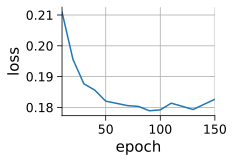

In [45]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1

lr, num_epochs, device = 0.005, 150, DEVICE

dataset = MTDataset(source, target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

encoder = Encoder(len(source_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Decoder(len(target_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, dataloader, lr, num_epochs, target_vocab, device)

### Evaluation

How do we know that we have obtained a good translation? BLEU (Bilingual Evaluation Understudy) is a metric that was developed specifically for this purpose. If you're curious, you can check out the details of the metric [here](https://d2l.ai/chapter_recurrent-modern/seq2seq.html?highlight=bleu#evaluation-of-predicted-sequences). For now, all you need to know is that a BLEU score lies between 0 and 1. The closer you are to 1, the better your translation is.

In [46]:
# @markdown Compute BLEU
def bleu(pred_seq, label_seq, k):
  """Compute the BLEU."""
  pred_tokens, label_tokens = [c for c in pred_seq], [c for c in label_seq]
  len_pred, len_label = len(pred_tokens), len(label_tokens)
  score = math.exp(min(0, 1 - len_label / len_pred))
  for n in range(1, k + 1):
    num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label - n + 1):
      label_subs[''.join(label_tokens[i: i + n])] += 1
    for i in range(len_pred - n + 1):
      if label_subs[''.join(pred_tokens[i: i + n])] > 0:
        num_matches += 1
        label_subs[''.join(pred_tokens[i: i + n])] -= 1
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
  return score

Implementing a function to make a translation of a given word. 

In [47]:
def predict_seq2seq(net, src_sentence):
  """Predict for sequence to sequence."""
  # Set `net` to eval mode for inference
  net.eval()
  src_tokens = [source_vocab[c] for c in src_sentence.lower()] + [source_vocab['<eos>']]
  # enc_valid_len = torch.tensor([len(src_tokens)], device=device)
  src_tokens = truncate_pad(src_tokens, NUM_STEPS, source_vocab['<pad>'])
  # Add the batch axis
  enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
  enc_outputs = net.encoder(enc_X)
  dec_state = net.decoder.init_state(enc_outputs)
  # Add the batch axis
  dec_X = torch.unsqueeze(torch.tensor([target_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
  output_seq, attention_weight_seq = [], []
  for _ in range(NUM_STEPS):
    Y, dec_state = net.decoder(dec_X, dec_state)
    # We use the token with the highest prediction likelihood as the input
    # of the decoder at the next time step
    dec_X = Y.argmax(dim=2)
    pred = dec_X.squeeze(dim=0).type(torch.int32).item()
    # Once the end-of-sequence token is predicted, the generation of the
    # output sequence is complete
    if pred == target_vocab['<eos>']:
      break
    output_seq.append(pred)
  return output_seq

In [48]:
engs = ['middle', 'funny', 'hour', 'igloo', 'vendor', 'moody']
pig_latin = ['iddlemay', 'unnyfay', 'ourhay', 'iglooway', 'endorvay', 'oodymay']

column_width = 18

print('English'.ljust(column_width) + 'Pig Latin'.ljust(column_width) + 'Translation'.ljust(column_width) + 'BLEU\n--------------------------------------------------------------')

for eng, pig in zip(engs, pig_latin):
  translation = predict_seq2seq(net, eng)
  translation = ''.join([target_idx2token[i] for i in translation])
  print(eng.ljust(column_width) + pig.ljust(column_width) + translation.ljust(column_width) + '%.3f' % bleu(translation, pig, k=2))

English           Pig Latin         Translation       BLEU
--------------------------------------------------------------
middle            iddlemay          entyay            0.339
funny             unnyfay           untay             0.504
hour              ourhay            outyay            0.649
igloo             iglooway          eray              0.198
vendor            endorvay          untay             0.301
moody             oodymay           oytytay           0.483


---
# Summary

In [49]:
# @title Video 8: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="J4zok8b2SUA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 8: Summary')

display(out)

In this tutorial, we went through applications of Recurrent Neural Networks for Natural Language Processing.

We introduced a basic RNN architecture and how it compares with CNNs to demonstrate the advantage of recurrence. The downside of RNNs is that they're prone to the issue of vanishing gradients while processing long-range dependencies. More complex architectures of RNNs are used in practice to tackle this problem, such as Gated Recurrent Units(GRU) [[PyTorch - nn.GRU()]](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) and Long Short-term Memory (LSTM) [[PyTorch - nn.LSTM()]](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

Finally, we explored three applications:
* Text Generation
* Sequence Tagging
* Language Translation

In [50]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus 1: Exploring input length for RNNs

Let's further explore how do different models perform based on length of the text we use as input. We'll use the IMDB dataset and the Vanilla RNN model defined in Section 1.

Let's increase the `sentence_length` to see how RNN performs when long reviews are allowed. We have set the length to 200 words, feel free to experiment with the length!

In [51]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(50)
TEXT_long, vocab_size_long, train_iter_long, valid_iter_long, test_iter_long = load_dataset(200)

Extracting all the files now...
Done!
Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021
Extracting all the files now...
Done!
Data loading is completed. Sentence length: 200, Batch size: 32, and seed: 2021


In [52]:
# Model hyperparamters
learning_rate = 0.0002
output_size = 2
hidden_size = 100
embedding_length = 100
epochs = 10

# Train the Vanilla RNN on the datasets
print('Training Vanilla RNN on sentence_length = 50\n')
# Initialize model, training and testing
vanilla_rnn_model = VanillaRNN(output_size, hidden_size, vocab_size, embedding_length)
vanilla_rnn_model.to(DEVICE)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model, DEVICE, train_iter, valid_iter, epochs, learning_rate)
print(f"--- Time taken to train = {time.time() - vanilla_rnn_start_time} seconds ---")
test_accuracy = test(vanilla_rnn_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy}%')
# Number of model parameters
paramters = count_parameters(vanilla_rnn_model)
print(f'Number of parameters = {paramters}')

print('Training Vanilla RNN on sentence_length = 200\n')
# Initialize model, training, testing
vanilla_rnn_model_long = VanillaRNN(output_size, hidden_size, vocab_size_long, embedding_length)
vanilla_rnn_model_long.to(DEVICE)
vanilla_rnn_start_time_long = time.time()
vanilla_train_loss_long, vanilla_train_acc_long, vanilla_validation_loss_long, vanilla_validation_acc_long = train(vanilla_rnn_model_long, DEVICE, train_iter_long, valid_iter_long, epochs, learning_rate)
print(f"--- Time taken to train = {time.time() - vanilla_rnn_start_time} seconds ---")
test_accuracy = test(vanilla_rnn_model_long, DEVICE, test_iter_long)
print(f'Test Accuracy: {test_accuracy}%')
# Number of parameters
paramters = count_parameters(vanilla_rnn_model_long)
print(f'Number of parameters = {paramters}')

Training Vanilla RNN on sentence_length = 50

Epoch: 1,  Training Loss: 0.6974, Training Accuracy:  50.82%
Validation Loss: 0.6969, Validation Accuracy:  50.31% 

Epoch: 2,  Training Loss: 0.6866, Training Accuracy:  54.83%
Validation Loss: 0.6902, Validation Accuracy:  54.25% 

Epoch: 3,  Training Loss: 0.6726, Training Accuracy:  58.23%
Validation Loss: 0.6792, Validation Accuracy:  58.13% 

Epoch: 4,  Training Loss: 0.6457, Training Accuracy:  63.21%
Validation Loss: 0.6538, Validation Accuracy:  62.72% 

Epoch: 5,  Training Loss: 0.6220, Training Accuracy:  65.81%
Validation Loss: 0.6520, Validation Accuracy:  62.83% 

Epoch: 6,  Training Loss: 0.5896, Training Accuracy:  69.39%
Validation Loss: 0.6420, Validation Accuracy:  65.52% 

Epoch: 7,  Training Loss: 0.5680, Training Accuracy:  71.13%
Validation Loss: 0.6379, Validation Accuracy:  65.73% 

Epoch: 8,  Training Loss: 0.5280, Training Accuracy:  74.55%
Validation Loss: 0.6380, Validation Accuracy:  67.49% 

Epoch: 9,  Trainin

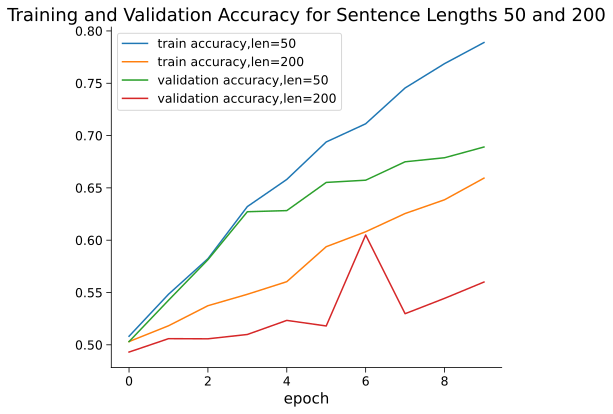

In [53]:
# Compare accuracies of model trained on different sentence lengths

x_ticks = np.arange(epochs)
plt.plot(x_ticks, vanilla_train_acc, label='train accuracy,len=50')
plt.plot(x_ticks, vanilla_train_acc_long, label='train accuracy,len=200')

plt.plot(x_ticks, vanilla_validation_acc, label='validation accuracy,len=50')
plt.plot(x_ticks, vanilla_validation_acc_long, label='validation accuracy,len=200')

plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy for Sentence Lengths 50 and 200")
plt.show()

---
# Bonus 2: Improving Text Generation

As seen in Section 2.1, choosing the character with the highest probability at each time step did not fully allow us to explore language variability. For this, we must also let the model "explore" other character choices. One of the ways to do this is to sample from a probability distribution. 

Implement the function to generate text again, but we cast the output to a probability distribution this time. Your task is to sample a character from this distribution. Use the PyTorch [multinomial function](https://pytorch.org/docs/stable/generated/torch.multinomial.html).

**Network**

In [54]:
class GenerationRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(GenerationRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers

    self.encoder = nn.Embedding(input_size, hidden_size)
    self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
    self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    input = self.encoder(input.view(1, -1))
    output, hidden = self.rnn(input, hidden)
    output = self.decoder(hidden.view(1, -1))
    return output, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

### Bonus Coding Exercise 1: Improving Text Generation



In [55]:
def evaluateMultinomial(net, prime_str, predict_len, temperature=0.8):
  hidden = net.init_hidden()
  predicted = prime_str

  # "Building up" the hidden state
  for p in range(len(prime_str) - 1):
    inp = char_tensor(prime_str[p])
    _, hidden = net(inp, hidden)

  # Tensorize of the last character
  inp = char_tensor(prime_str[-1])

  # For every index to predict
  for p in range(predict_len):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Generation Improve")
    ####################################################################
    # Pass the character + previous hidden state to the model
    output, hidden = ...

    # Sample from the network as a multinomial distribution
    output_dist = output.data.view(-1).div(temperature).exp()
    top_i = ...

    # Add predicted character to string and use as next input
    predicted_char = all_characters[top_i]
    predicted += predicted_char
    inp = char_tensor(predicted_char)

  return predicted


## Uncomment to run
# sampleDecoder = GenerationRNN(27, 100, 27, 1)
# text = evaluateMultinomial(sampleDecoder, 'hi', 10)
# if text.startswith('hi') and len(text) == 12:
#   print('Success!')
# else:
#   print('Need to change.')

In [56]:
# to_remove solution
def evaluateMultinomial(net, prime_str, predict_len, temperature=0.8):
  hidden = net.init_hidden()
  predicted = prime_str

  # "Building up" the hidden state
  for p in range(len(prime_str) - 1):
    inp = char_tensor(prime_str[p])
    _, hidden = net(inp, hidden)

  # Tensorize of the last character
  inp = char_tensor(prime_str[-1])

  # For every index to predict
  for p in range(predict_len):
    # Pass the character + previous hidden state to the model
    output, hidden = net(inp, hidden)

    # Sample from the network as a multinomial distribution
    output_dist = output.data.view(-1).div(temperature).exp()
    top_i = torch.multinomial(output_dist, 1)[0]

    # Add predicted character to string and use as next input
    predicted_char = all_characters[top_i]
    predicted += predicted_char
    inp = char_tensor(predicted_char)

  return predicted


## Uncomment to run
sampleDecoder = GenerationRNN(27, 100, 27, 1)
text = evaluateMultinomial(sampleDecoder, 'hi', 10)
if text.startswith('hi') and len(text) == 12:
  print('Success!')
else:
  print('Need to change.')

Success!


Epoch 500 --------------------
	 this anal he icus sor mestus at fre all teer you is 
Epoch 1000 --------------------
	 the hin forite iif lort od ase ur carsui do ende bep
Epoch 1500 --------------------
	 that dodlibe brutus of you bherd strony ut ty brifla
Epoch 2000 --------------------
	 the and gith by luntion coppont to siciny brutus of 
Epoch 2500 --------------------
	 the hourstany looth love cassius of recere tholl an 
Epoch 3000 --------------------
	 thing but the sotesmans mait cassius not still what 


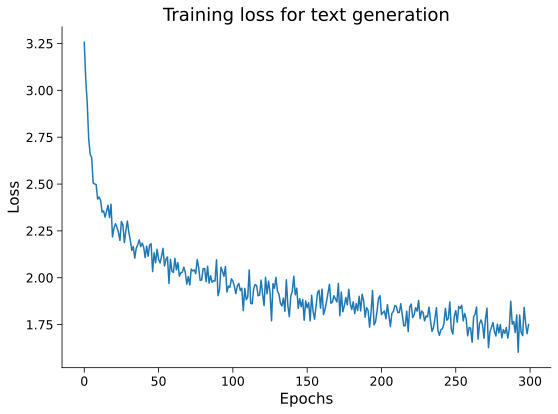

In [57]:
# @title Execute cell to train the model

def grad_clipping(net, theta):
  """Clip the gradient."""
  params = [p for p in net.parameters() if p.requires_grad]

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))

  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm


# Single training step
def train_simple2(inp, target, chunk_len):
  # Initialize hidden state, zero the gradients of decoder
  hidden = decoder.init_hidden()
  decoder.zero_grad()
  loss = 0

  # For each character in our chunk (except last), compute the hidden and ouput
  # Using each output, compute the loss with the corresponding target
  for c in range(chunk_len):
    output, hidden = decoder(inp[c], hidden)
    loss += criterion(output, target[c].unsqueeze(0))

  # Backpropagate, clip gradient and optimize
  loss.backward()
  grad_clipping(decoder, 1)
  decoder_optimizer.step()

  # Return average loss
  return loss.data.item() / chunk_len


n_epochs = 3000
hidden_size = 100
n_layers = 1
lr = 0.0005
print_every, plot_every = 500, 10

# Create model, optimizer and loss function
decoder = GenerationRNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

# For every epoch
for epoch in range(1, n_epochs + 1):
  # Get a random (input, target) pair from training set and perform one training iteration
  loss = train_simple2(*random_training_set(chunk_len), chunk_len)
  loss_avg += loss

  if epoch % print_every == 0:
    text = evaluateMultinomial(decoder, 'th', 50)
    print(f'Epoch {epoch} --------------------\n\t {text}')

  if epoch % plot_every == 0:
    all_losses.append(loss_avg / plot_every)
    loss_avg = 0

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss for text generation')
plt.show()